In [22]:
import pandas as pd
import numpy as np
import quandl
import math
import matplotlib.pyplot as plt
from sklearn import cross_validation,svm,preprocessing
from sklearn.linear_model import LinearRegression
import datetime
from matplotlib import style
import pickle
style.use('ggplot')

In [2]:
df=quandl.get('WIKI/GOOGL')

In [4]:
df=df[['Adj. Open','Adj. High','Adj. Low','Adj. Close','Adj. Volume']]
df['HL_PCT']= (df['Adj. High']-df['Adj. Close'])/df['Adj. Close']*100.0
df['PCT_change']= (df['Adj. Close']-df['Adj. Open'])/df['Adj. Open']*100.0

In [5]:
df=df[['Adj. Close','HL_PCT','PCT_change','Adj. Volume']]

In [6]:
forecast_col='Adj. Close'
df.fillna(-99999,inplace=True)

In [7]:
forecast_out=int(math.ceil(0.01*len(df)))
df['label']=df[forecast_col].shift(-forecast_out)

In [8]:
X=np.array(df.drop(['label'],1))
X=preprocessing.scale(X)
X_lately=X[-forecast_out:]
X=X[:-forecast_out]
df.dropna(inplace=True)
y=np.array(df['label'])

In [9]:
X_train,X_test,y_train,y_test=cross_validation.train_test_split(X,y,test_size=0.2)


In [40]:
clf=LinearRegression(n_jobs=-1)
#clf=svm.SVR(kernel='poly')
clf.fit(X_train,y_train)

#saving a classifier - pickling
with open('linearregression.pickle','wb') as f:
    pickle.dump(clf,f)
pickle_in=open('linearregression.pickle','rb')
clf = pickle.load(pickle_in)

In [41]:
accuracy=clf.score(X_test,y_test)

forecast_set=clf.predict(X_lately)
print(forecast_set,accuracy,forecast_out)

[1103.19752738 1073.65626672 1019.86416272 1062.24685854 1074.4559508
 1074.62296554 1093.28250599 1112.72464457 1115.71461634 1123.62775385
 1132.75760051 1130.56911384 1150.25136805 1165.9467304  1137.27066715
 1123.48023482 1088.94737327 1104.39776943 1115.34904486 1122.66787083
 1136.35724724 1151.21208793 1182.79783782 1187.20377258 1158.67873106
 1170.04567876 1171.84018502 1154.66325385 1120.01939396 1116.47443537
 1113.95296224 1071.07872288 1042.80466502 1074.45855006 1021.4882899 ] 0.977327607504003 35


            Adj. Close    HL_PCT  PCT_change  Adj. Volume      label  Forecast
Date                                                                          
2004-08-19   50.322842  3.712563    0.324968   44659000.0  69.078238       NaN
2004-08-20   54.322689  0.710922    7.227007   22834300.0  67.839414       NaN
2004-08-23   54.869377  3.729433   -1.227880   18256100.0  68.912727       NaN
2004-08-24   52.597363  6.417469   -5.726357   15247300.0  70.668146       NaN
2004-08-25   53.164113  1.886792    1.183658    9188600.0  71.219849       NaN


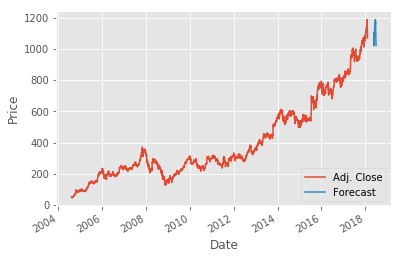

In [20]:
df['Forecast']=np.nan

last_date=df.iloc[-1].name
last_unix=last_date.timestamp()
one_day=86400
next_unix=last_unix+one_day

for i in forecast_set:
    next_date=datetime.datetime.fromtimestamp(next_unix)
    next_unix+=one_day
    df.loc[next_date]=[np.nan for _ in range(len(df.columns)-1)] +[i]

print(df.head())    
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()